In [1]:
import autoreg
import GPy
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
%matplotlib inline

from autoreg.benchmark import tasks

In [2]:
# Function to compute root mean square error:

def comp_RMSE(a,b):
    return np.sqrt(np.square(a-b).mean())

In [3]:
# Define class for normalization
class Normalize(object):
    
    def __init__(self, data, name, norm_name):
        
        self.data_mean = data.mean(axis=0)
        self.data_std = data.std(axis=0)
        self.normalization_computed = True
        
        setattr(self, name, data)                         
        setattr(self, norm_name, (data-self.data_mean) / self.data_std )
        
    def normalize(self, data, name, norm_name):
            if hasattr(self,norm_name):
                raise ValueError("This normalization name already exist, choose another one")
            
            setattr(self, name, data )
            setattr(self, norm_name, (data-self.data_mean) / self.data_std )
            
            
                                     
    def denormalize(self, data):
                                   
        return data*self.data_std + self.data_mean    

In [4]:
trainned_models_folder_name = "/Users/grigoral/work/code/RGP/examples/identif_trainded"
task_name = 'IdentificationExample5'
# task names:
# Actuator, Ballbeam, Drive, Gas_furnace, Flutter, Dryer, Tank,
# IdentificationExample1..5

In [5]:
task = getattr( tasks, task_name)
task = task()
task.load_data()
print("Data OUT train shape:  ", task.data_out_train.shape)
print("Data IN train shape:  ", task.data_in_train.shape)
print("Data OUT test shape:  ", task.data_out_test.shape)
print("Data IN test shape:  ", task.data_in_test.shape)

Data OUT train shape:   (300, 1)
Data IN train shape:   (300, 1)
Data OUT test shape:   (300, 1)
Data IN test shape:   (300, 1)


### Normalize training and test data:

In [6]:
normalize = False
in_data = Normalize(task.data_in_train,'in_train','in_train_norm' )
out_data = Normalize(task.data_out_train,'out_train','out_train_norm' )

in_data.normalize(task.data_in_test, 'in_test','in_test_norm')
out_data.normalize(task.data_out_test, 'out_test','out_test_norm')

if normalize:
    out_train = out_data.out_train_norm #out_data.out_train 
    in_train = in_data.in_train_norm # in_data.in_train
    out_test = out_data.out_test_norm #out_data.out_test
    in_test = in_data.in_test_norm #in_data.in_test
else:
    out_train = out_data.out_train  #out_data.out_train 
    in_train = in_data.in_train # in_data.in_train
    out_test = out_data.out_test #out_data.out_test
    in_test = in_data.in_test #in_data.in_test

print("Training OUT mean:  ", out_train.mean(0)); 
print("Training OUT std:  ", out_train.std(0))
print("")
print("Test OUT mean:  ", out_test.mean(0)); 
print("Test OUT std:  ", out_test.std(0))
print("")
print("Training IN mean:  ", in_train.mean(0)); 
print("Training IN std:  ", in_train.std(0))
print("")
print("Test IN mean:  ", in_test.mean(0)); 
print("Test IN std:  ", in_test.std(0))

Training OUT mean:   [ 0.05968174]
Training OUT std:   [ 1.87727311]

Test OUT mean:   [ 0.23458633]
Test OUT std:   [ 1.70671659]

Training IN mean:   [ 0.16261821]
Training IN std:   [ 1.48605093]

Test IN mean:   [  9.17784367e-17]
Test IN std:   [ 1.]


### Plot training and test data:

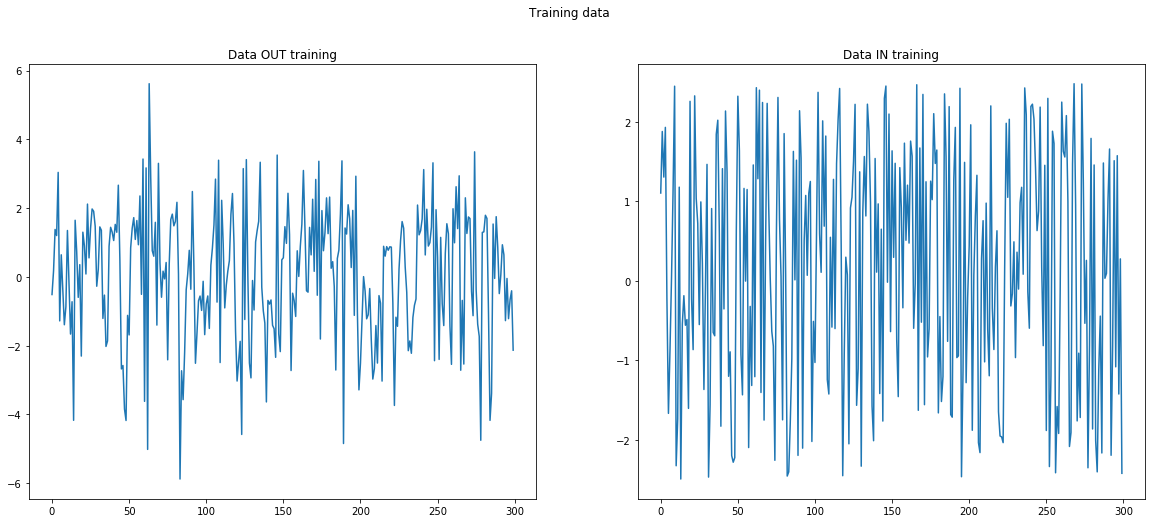

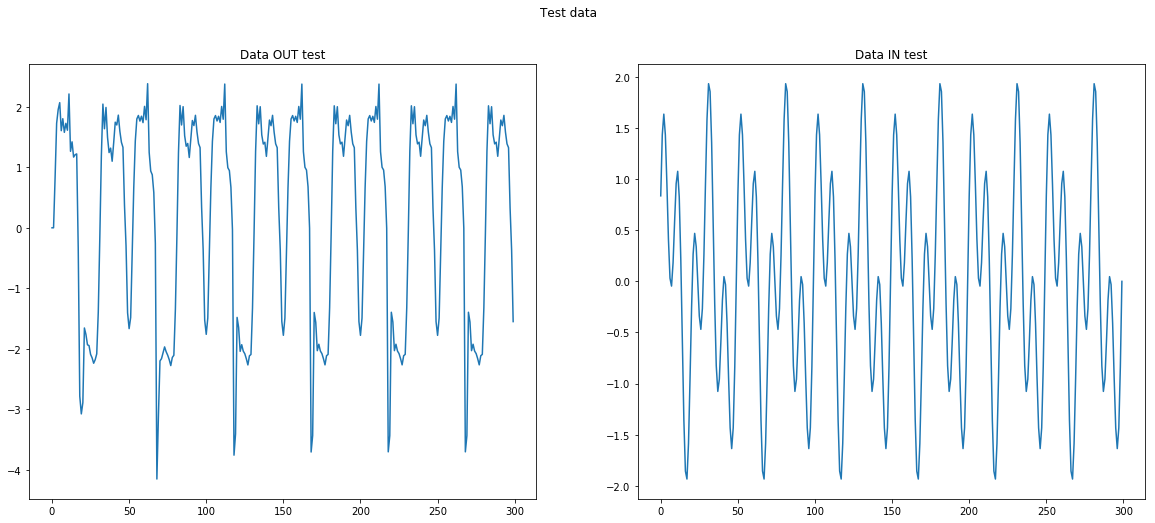

In [7]:
# Plot training:
fig1 = plt.figure(1,figsize=(20,8))
fig1.suptitle('Training data')
ax1 = plt.subplot(1,2,1)
ax1.plot(out_train)
ax1.set_title('Data OUT training')

ax2 = plt.subplot(1,2,2)
ax2.plot(in_train)
ax2.set_title('Data IN training')

fig2 = plt.figure(2,figsize=(20,8))
fig2.suptitle('Test data')
ax3 = plt.subplot(1,2,1)
ax3.plot(out_test)
ax3.set_title('Data OUT test')

ax4 = plt.subplot(1,2,2)
ax4.plot(in_test)
ax4.set_title('Data IN test')

del ax1, ax2, ax3, ax4

### Model definition:

In [49]:
Q = 50 # 200 # Inducing points num
win_in = task.win_in # 20
win_out = task.win_out # 20
use_controls = True
back_cstr = False
inference_method = 'svi'

# 1 layer:
wins = [0, win_out] # 0-th is output layer
nDims = [out_train.shape[1],1]

# 2 layers:
# wins = [0, win_out, win_out]
# nDims = [out_train.shape[1],1,1]

MLP_dims = [300,200]
print("Input window:  ", win_in)
print("Output window:  ", win_out)


m = autoreg.DeepAutoreg_new(wins, out_train, U=in_train, U_win=win_in,
                        num_inducing=Q, back_cstr=back_cstr, MLP_dims=MLP_dims, nDims=nDims,
                        init='Y', # how to initialize hidden states means
                        X_variance=0.05, # how to initialize hidden states variances
                        inference_method=inference_method, # Inference method
                        # 1 layer:
                        kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True),
                                 GPy.kern.RBF(win_in + win_out,ARD=True,inv_l=True)] )

                        # 2 layers:
                        #kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True),
                        #         GPy.kern.RBF(win_out+win_out,ARD=True,inv_l=True),
                        #         GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True)])
        
#m = autoreg.DeepAutoreg([0,win_out],out_train, U=in_train, U_win=win_in,X_variance=0.01,
#                        num_inducing=50)

# pattern for model name: #task_name, inf_meth=?, wins=layers, Q = ?, backcstr=?,MLP_dims=?, nDims=
model_file_name = '%s--inf_meth=%s--wins=%s--Q=%i--backcstr=%i--nDims=%s' % (task.name, 
    'reg' if inference_method is None else inference_method, str(wins), Q, back_cstr, str(nDims))
if back_cstr == True:
    model_file_name += '--MLP_dims=%s' % (MLP_dims,)
    
print('Model file name:  ',  model_file_name)
print(m)
m.checkgrad(verbose=True)

Input window:   5
Output window:   5
Model file name:   IdentificationExample5--inf_meth=svi--wins=[0, 5]--Q=3--backcstr=0--nDims=[1, 1]

Name : autoreg
Objective : 68283.6643485
Number of Parameters : 690
Number of Optimization Parameters : 690
Updates : True
Parameters:
  autoreg.                         |     value  |  constraints  |  priors
  layer_1.inducing_inputs          |   (3, 10)  |               |        
  layer_1.rbf.variance             |       1.0  |      +ve      |        
  layer_1.rbf.inv_lengthscale      |     (10,)  |      +ve      |        
  layer_1.Gaussian_noise.variance  |      0.01  |      +ve      |        
  layer_1.qU_m                     |    (3, 1)  |               |        
  layer_1.qU_W                     |    (3, 3)  |               |        
  layer_1.qU_a                     |     0.001  |      +ve      |        
  layer_1.qX_0.mean                |  (300, 1)  |               |        
  layer_1.qX_0.variance            |  (300, 1)  |      +ve   

 autoreg.layer_1.qU_W[[1 2]]                 |   0.999999    |   0.000001    |   1.839007    |   1.839006    |     5e-11     
 autoreg.layer_1.qU_W[[2 0]]                 |   1.000002    |   0.000003    |   -1.709607   |   -1.709610   |     5e-11     
 autoreg.layer_1.qU_W[[2 1]]                 |   1.000000    |   0.000000    |   -1.607070   |   -1.607070   |     5e-11     
 autoreg.layer_1.qU_W[[2 2]]                 |   0.999999    |   0.000001    |   1.756737    |   1.756736    |     5e-11     
 autoreg.layer_1.qU_a                        |   1.000003    |   0.000004    |   -1.317970   |   -1.317974   |     4e-11     
 autoreg.layer_1.qX_0.mean[[0 0]]            |   1.000024    |   0.000002    |   0.088037    |   0.088039    |     3e-12     
 autoreg.layer_1.qX_0.mean[[1 0]]            |   0.999992    |   0.000003    |   0.393218    |   0.393215    |     1e-11     
 autoreg.layer_1.qX_0.mean[[2 0]]            |   0.999998    |   0.000001    |   0.647969    |   0.647968    |     2e-

 autoreg.layer_1.qX_0.mean[[57  0]]          |   1.000000    |   0.000002    |  235.667094   |  235.667096   |     7e-09     
 autoreg.layer_1.qX_0.mean[[58  0]]          |   1.000000    |   0.000008    |  -50.848247   |  -50.848255   |     1e-09     
 autoreg.layer_1.qX_0.mean[[59  0]]          |   1.000000    |   0.000004    |  342.857977   |  342.857973   |     1e-08     
 autoreg.layer_1.qX_0.mean[[60  0]]          |   1.000000    |   0.000014    |  -361.907033  |  -361.907019  |     1e-08     
 autoreg.layer_1.qX_0.mean[[61  0]]          |   1.000000    |   0.000003    |  317.041037   |  317.041035   |     9e-09     
 autoreg.layer_1.qX_0.mean[[62  0]]          |   1.000000    |   0.000008    |  -501.611875  |  -501.611867  |     1e-08     
 autoreg.layer_1.qX_0.mean[[63  0]]          |   1.000000    |   0.000007    |  561.960340   |  561.960347   |     2e-08     
 autoreg.layer_1.qX_0.mean[[64  0]]          |   1.000000    |   0.000007    |  290.159376   |  290.159369   |     8e-

 autoreg.layer_1.qX_0.mean[[120   0]]        |   1.000000    |   0.000003    |  -303.217112  |  -303.217115  |     9e-09     
 autoreg.layer_1.qX_0.mean[[121   0]]        |   1.000000    |   0.000004    |  -247.029110  |  -247.029115  |     7e-09     
 autoreg.layer_1.qX_0.mean[[122   0]]        |   1.000000    |   0.000002    |  -187.369109  |  -187.369107  |     5e-09     
 autoreg.layer_1.qX_0.mean[[123   0]]        |   1.000000    |   0.000002    |  -458.153592  |  -458.153590  |     1e-08     
 autoreg.layer_1.qX_0.mean[[124   0]]        |   1.000000    |   0.000002    |  314.974639   |  314.974641   |     9e-09     
 autoreg.layer_1.qX_0.mean[[125   0]]        |   1.000000    |   0.000004    |  -123.803290  |  -123.803286  |     4e-09     
 autoreg.layer_1.qX_0.mean[[126   0]]        |   1.000000    |   0.000007    |  341.128841   |  341.128834   |     1e-08     
 autoreg.layer_1.qX_0.mean[[127   0]]        |   0.999999    |   0.000003    |   -2.307799   |   -2.307796   |     7e-

 autoreg.layer_1.qX_0.mean[[185   0]]        |   1.000000    |   0.000012    |   53.707374   |   53.707387   |     2e-09     
 autoreg.layer_1.qX_0.mean[[186   0]]        |   1.000000    |   0.000012    |   77.695896   |   77.695884   |     2e-09     
 autoreg.layer_1.qX_0.mean[[187   0]]        |   1.000000    |   0.000001    |  182.594332   |  182.594333   |     5e-09     
 autoreg.layer_1.qX_0.mean[[188   0]]        |   1.000000    |   0.000006    |  337.549144   |  337.549151   |     1e-08     
 autoreg.layer_1.qX_0.mean[[189   0]]        |   1.000000    |   0.000003    |  -484.499765  |  -484.499767  |     1e-08     
 autoreg.layer_1.qX_0.mean[[190   0]]        |   1.000000    |   0.000008    |  142.420206   |  142.420198   |     4e-09     
 autoreg.layer_1.qX_0.mean[[191   0]]        |   1.000000    |   0.000008    |  124.764315   |  124.764323   |     4e-09     
 autoreg.layer_1.qX_0.mean[[192   0]]        |   1.000000    |   0.000006    |  210.199743   |  210.199738   |     6e-

 autoreg.layer_1.qX_0.mean[[250   0]]        |   1.000000    |   0.000011    |   56.667366   |   56.667377   |     2e-09     
 autoreg.layer_1.qX_0.mean[[251   0]]        |   1.000000    |   0.000000    |  -239.916124  |  -239.916124  |     7e-09     
 autoreg.layer_1.qX_0.mean[[252   0]]        |   1.000000    |   0.000016    |  115.046415   |  115.046430   |     3e-09     
 autoreg.layer_1.qX_0.mean[[253   0]]        |   1.000000    |   0.000002    |  -77.740015   |  -77.740013   |     2e-09     
 autoreg.layer_1.qX_0.mean[[254   0]]        |   1.000000    |   0.000009    |  -141.507526  |  -141.507517  |     4e-09     
 autoreg.layer_1.qX_0.mean[[255   0]]        |   1.000000    |   0.000002    |   68.436350   |   68.436348   |     2e-09     
 autoreg.layer_1.qX_0.mean[[256   0]]        |   1.000000    |   0.000004    |  154.696976   |  154.696972   |     5e-09     
 autoreg.layer_1.qX_0.mean[[257   0]]        |   1.000000    |   0.000006    |  125.579971   |  125.579965   |     4e-

 autoreg.layer_1.qX_0.variance[[14  0]]      |   0.999997    |   0.000007    |   1.937180    |   1.937173    |     6e-11     
 autoreg.layer_1.qX_0.variance[[15  0]]      |   0.999997    |   0.000006    |   1.940889    |   1.940884    |     6e-11     
 autoreg.layer_1.qX_0.variance[[16  0]]      |   0.999993    |   0.000014    |   1.935623    |   1.935608    |     6e-11     
 autoreg.layer_1.qX_0.variance[[17  0]]      |   0.999993    |   0.000013    |   1.940460    |   1.940447    |     6e-11     
 autoreg.layer_1.qX_0.variance[[18  0]]      |   0.999997    |   0.000006    |   1.939441    |   1.939436    |     6e-11     
 autoreg.layer_1.qX_0.variance[[19  0]]      |   0.999990    |   0.000019    |   1.939578    |   1.939559    |     6e-11     
 autoreg.layer_1.qX_0.variance[[20  0]]      |   0.999996    |   0.000007    |   1.952728    |   1.952722    |     6e-11     
 autoreg.layer_1.qX_0.variance[[21  0]]      |   0.999994    |   0.000011    |   1.982979    |   1.982968    |     6e-

 autoreg.layer_1.qX_0.variance[[79  0]]      |   0.999998    |   0.000004    |   1.964979    |   1.964974    |     6e-11     
 autoreg.layer_1.qX_0.variance[[80  0]]      |   0.999995    |   0.000011    |   1.956312    |   1.956301    |     6e-11     
 autoreg.layer_1.qX_0.variance[[81  0]]      |   0.999993    |   0.000014    |   1.943044    |   1.943030    |     6e-11     
 autoreg.layer_1.qX_0.variance[[82  0]]      |   0.999996    |   0.000009    |   1.951384    |   1.951375    |     6e-11     
 autoreg.layer_1.qX_0.variance[[83  0]]      |   0.999995    |   0.000009    |   1.950817    |   1.950808    |     6e-11     
 autoreg.layer_1.qX_0.variance[[84  0]]      |   0.999997    |   0.000006    |   1.946994    |   1.946988    |     6e-11     
 autoreg.layer_1.qX_0.variance[[85  0]]      |   0.999999    |   0.000002    |   1.943017    |   1.943015    |     6e-11     
 autoreg.layer_1.qX_0.variance[[86  0]]      |   0.999991    |   0.000018    |   1.949742    |   1.949724    |     6e-

 autoreg.layer_1.qX_0.variance[[141   0]]    |   0.999993    |   0.000013    |   1.948966    |   1.948953    |     6e-11     
 autoreg.layer_1.qX_0.variance[[142   0]]    |   0.999997    |   0.000006    |   1.979197    |   1.979191    |     6e-11     
 autoreg.layer_1.qX_0.variance[[143   0]]    |   0.999995    |   0.000011    |   1.983379    |   1.983368    |     6e-11     
 autoreg.layer_1.qX_0.variance[[144   0]]    |   0.999995    |   0.000011    |   1.988275    |   1.988265    |     6e-11     
 autoreg.layer_1.qX_0.variance[[145   0]]    |   0.999998    |   0.000003    |   1.961514    |   1.961511    |     6e-11     
 autoreg.layer_1.qX_0.variance[[146   0]]    |   0.999996    |   0.000007    |   1.950837    |   1.950830    |     6e-11     
 autoreg.layer_1.qX_0.variance[[147   0]]    |   0.999996    |   0.000008    |   1.956804    |   1.956796    |     6e-11     
 autoreg.layer_1.qX_0.variance[[148   0]]    |   0.999991    |   0.000017    |   1.942552    |   1.942535    |     6e-

 autoreg.layer_1.qX_0.variance[[204   0]]    |   0.999994    |   0.000012    |   1.942184    |   1.942171    |     6e-11     
 autoreg.layer_1.qX_0.variance[[205   0]]    |   1.000000    |   0.000001    |   1.955100    |   1.955101    |     6e-11     
 autoreg.layer_1.qX_0.variance[[206   0]]    |   0.999998    |   0.000003    |   1.957862    |   1.957858    |     6e-11     
 autoreg.layer_1.qX_0.variance[[207   0]]    |   0.999998    |   0.000004    |   1.966463    |   1.966459    |     6e-11     
 autoreg.layer_1.qX_0.variance[[208   0]]    |   0.999994    |   0.000011    |   1.946090    |   1.946079    |     6e-11     
 autoreg.layer_1.qX_0.variance[[209   0]]    |   0.999994    |   0.000011    |   1.955003    |   1.954992    |     6e-11     
 autoreg.layer_1.qX_0.variance[[210   0]]    |   0.999996    |   0.000007    |   1.948574    |   1.948567    |     6e-11     
 autoreg.layer_1.qX_0.variance[[211   0]]    |   1.000001    |   0.000002    |   1.954415    |   1.954417    |     6e-

 autoreg.layer_1.qX_0.variance[[268   0]]    |   0.999995    |   0.000009    |   1.949238    |   1.949229    |     6e-11     
 autoreg.layer_1.qX_0.variance[[269   0]]    |   0.999999    |   0.000002    |   1.947783    |   1.947781    |     6e-11     
 autoreg.layer_1.qX_0.variance[[270   0]]    |   0.999995    |   0.000010    |   1.949450    |   1.949440    |     6e-11     
 autoreg.layer_1.qX_0.variance[[271   0]]    |   0.999995    |   0.000011    |   1.953940    |   1.953929    |     6e-11     
 autoreg.layer_1.qX_0.variance[[272   0]]    |   0.999998    |   0.000004    |   1.949066    |   1.949062    |     6e-11     
 autoreg.layer_1.qX_0.variance[[273   0]]    |   0.999997    |   0.000006    |   1.951113    |   1.951106    |     6e-11     
 autoreg.layer_1.qX_0.variance[[274   0]]    |   0.999997    |   0.000005    |   1.950420    |   1.950415    |     6e-11     
 autoreg.layer_1.qX_0.variance[[275   0]]    |   0.999997    |   0.000006    |   1.950880    |   1.950873    |     6e-

 autoreg.layer_0.qU_W[[1 2]]                 |   1.000000    |   0.000002    |   5.147185    |   5.147187    |     2e-10     
 autoreg.layer_0.qU_W[[2 0]]                 |   1.000000    |   0.000000    |   8.227296    |   8.227296    |     2e-10     
 autoreg.layer_0.qU_W[[2 1]]                 |   1.000001    |   0.000003    |   4.424427    |   4.424430    |     1e-10     
 autoreg.layer_0.qU_W[[2 2]]                 |   1.000000    |   0.000000    |   2.233297    |   2.233297    |     7e-11     
 autoreg.layer_0.qU_a                        |   1.000001    |   0.000001    |   -1.304825   |   -1.304827   |     4e-11     


True

### Model initialization:

In [36]:
# Here layer numbers are different than in initialization. 0-th layer is the top one
for i in range(m.nLayers):
    m.layers[i].kern.inv_l[:]  = np.mean( 1./((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.)) )
    m.layers[i].likelihood.variance[:] = 0.01*out_train.var()
    m.layers[i].kern.variance.fix(warning=False)
    m.layers[i].likelihood.fix(warning=False)
print(m)


Name : autoreg
Objective : 15409.2757564
Number of Parameters : 6471
Number of Optimization Parameters : 6467
Updates : True
Parameters:
  autoreg.                         |            value  |  constraints  |  priors
  layer_1.inducing_inputs          |         (50, 10)  |               |        
  layer_1.rbf.variance             |              1.0  |   +ve fixed   |        
  layer_1.rbf.inv_lengthscale      |            (10,)  |      +ve      |        
  layer_1.Gaussian_noise.variance  |  0.0352415434704  |   +ve fixed   |        
  layer_1.qU_m                     |          (50, 1)  |               |        
  layer_1.qU_W                     |         (50, 50)  |               |        
  layer_1.qU_a                     |            0.001  |      +ve      |        
  layer_1.qX_0.mean                |         (300, 1)  |               |        
  layer_1.qX_0.variance            |         (300, 1)  |      +ve      |        
  layer_0.inducing_inputs          |          (50, 5

In [37]:
print(m.layer_1.kern.inv_l)
print(m.layer_0.kern.inv_l)
print( np.mean(1./((m.layer_1.X.mean.values.max(0)-m.layer_1.X.mean.values.min(0))/np.sqrt(2.))) )

  index  |  autoreg.layer_1.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.20364643  |      +ve      |        
  [1]    |                           0.20364643  |      +ve      |        
  [2]    |                           0.20364643  |      +ve      |        
  [3]    |                           0.20364643  |      +ve      |        
  [4]    |                           0.20364643  |      +ve      |        
  [5]    |                           0.20364643  |      +ve      |        
  [6]    |                           0.20364643  |      +ve      |        
  [7]    |                           0.20364643  |      +ve      |        
  [8]    |                           0.20364643  |      +ve      |        
  [9]    |                           0.20364643  |      +ve      |        
  index  |  autoreg.layer_0.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.12300233  |      +ve      |        
  [1]    |               

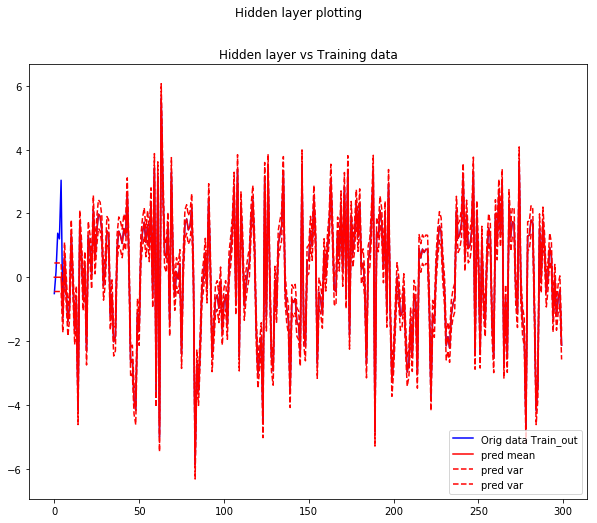

In [38]:
# Plot initialization of hidden layer:
def plot_hidden_states(fig_no, layer, layer_start_point=None, layer_end_point=None,
                              data_start_point=None, data_end_point=None):
    if layer_start_point is None: layer_start_point=0;
    if layer_end_point is None: layer_end_point = len(layer.mean)
    
    if data_start_point is None: data_start_point=0;
    if data_end_point is None: layer_end_point = len(out_train)
        
    data = out_train[data_start_point:data_end_point]
    layer_means = layer.mean[layer_start_point:layer_end_point]
    layer_vars = layer.variance[layer_start_point:layer_end_point]

    fig4 = plt.figure(fig_no,figsize=(10,8))
    ax1 = plt.subplot(1,1,1)
    fig4.suptitle('Hidden layer plotting')
    ax1.plot(out_train[data_start_point:data_end_point], label="Orig data Train_out", color = 'b')
    ax1.plot( layer_means, label = 'pred mean', color = 'r' )
    ax1.plot( layer_means +\
                     2*np.sqrt( layer_vars ), label = 'pred var', color='r', linestyle='--' )
    ax1.plot( layer_means -\
                     2*np.sqrt( layer_vars ), label = 'pred var', color='r', linestyle='--' )
    ax1.legend(loc=4)        
    ax1.set_title('Hidden layer vs Training data')

    del ax1

plot_hidden_states(5,m.layer_1.qX_0)
#plot_hidden_states(6,m.layer_2.qX_0)

### Model training:

In [39]:
#init_runs = 50 if out_train.shape[0]<1000 else 100
init_runs = 100
print("Init runs:  ", init_runs)
m.optimize('bfgs',messages=1,max_iters=init_runs)
for i in range(m.nLayers):
    m.layers[i].kern.variance.constrain_positive(warning=False)
    m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=10000)

print(m)

Init runs:   100
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s11  001   1.540928e+04   4.002577e+06 
    01s23  015   2.122730e+03   7.647174e+04 
    04s35  054   1.009164e+03   2.701847e+04 
    08s20  102   6.928191e+02   5.026328e+03 
Runtime:     08s20
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s18  00002   6.303080e+02   5.814468e+05 
    03s29  00041   4.868468e+02   1.091685e+03 
    04s33  00053   4.747719e+02   3.797151e+03 
    14s86  00173   4.435939e+02   6.000586e+02 
    20s08  00229   4.404461e+02   4.280249e+02 
    59s53  00659   4.363617e+02   3.818287e+01 
 01m07s86  00760   4.360309e+02   7.395294e+01 
 03m09s39  02135   4.343032e+02   1.293935e+01 
 07m58s16  05615   4.337770e+02   1.346399e+01 
Runtime:  07m58s16
Optimization status: Converged


Name : autoreg
Objective : 433.776951463
Number of

### Look at trained parameters

In [40]:
if hasattr(m, 'layer_1'):
    print("Layer 1:  ")
    print("States means (min and max), shapes:  ", m.layer_1.qX_0.mean.min(), 
          m.layer_1.qX_0.mean.max(), m.layer_1.qX_0.mean.shape)
    print("States variances (min and max), shapes:  ", m.layer_1.qX_0.variance.min(), 
          m.layer_1.qX_0.variance.max(), m.layer_1.qX_0.mean.shape)
    print("Inverse langthscales (min and max), shapes:  ", m.layer_1.rbf.inv_lengthscale.min(),
          m.layer_1.rbf.inv_lengthscale.max(), m.layer_1.rbf.inv_lengthscale.shape )
    
if hasattr(m, 'layer_0'):
    print("")
    print("Layer 0 (output):  ")
    print("Inverse langthscales (min and max), shapes:  ", m.layer_0.rbf.inv_lengthscale.min(),
          m.layer_0.rbf.inv_lengthscale.max(), m.layer_0.rbf.inv_lengthscale.shape )

Layer 1:  
States means (min and max), shapes:   -1.82693539616 2.12233556682 (300, 1)
States variances (min and max), shapes:   0.00070198191 0.865057396343 (300, 1)
Inverse langthscales (min and max), shapes:   1.31769235383e-08 0.753964668733 (10,)

Layer 0 (output):  
Inverse langthscales (min and max), shapes:   1.44814063387e-08 0.746273629423 (5,)


In [41]:
print(m.layer_0.rbf.inv_lengthscale)

  index  |  autoreg.layer_0.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.00221387  |      +ve      |        
  [1]    |                           0.00000001  |      +ve      |        
  [2]    |                           0.01447472  |      +ve      |        
  [3]    |                           0.74627363  |      +ve      |        
  [4]    |                           0.32789038  |      +ve      |        


In [42]:
print(m.layer_1.rbf.inv_lengthscale)

  index  |  autoreg.layer_1.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.00008952  |      +ve      |        
  [1]    |                           0.00000003  |      +ve      |        
  [2]    |                           0.00000004  |      +ve      |        
  [3]    |                           0.00167606  |      +ve      |        
  [4]    |                           0.75396467  |      +ve      |        
  [5]    |                           0.00000008  |      +ve      |        
  [6]    |                           0.00000001  |      +ve      |        
  [7]    |                           0.00007849  |      +ve      |        
  [8]    |                           0.00016292  |      +ve      |        
  [9]    |                           0.00149943  |      +ve      |        


### Analyze and plot model on test data:

In [43]:
# Free-run on the train data

# initialize to last part of trained latent states
#init_Xs = [None, m.layer_1.qX_0[0:win_out]] # init_Xs for train prediction

# initialize to zeros
init_Xs = None
predictions_train = m.freerun(init_Xs = init_Xs, U=in_train, m_match=True)

# initialize to last part of trainig latent states
#init_Xs = [None, m.layer_1.qX_0[-win_out:] ] # init_Xs for test prediction
#U_test = np.vstack( (in_train[-win_in:], in_test) )

# initialize to zeros
init_Xs = None
U_test = in_test

# Free-run on the test data
predictions_test = m.freerun(init_Xs = init_Xs, U=U_test, m_match=True)
del init_Xs, U_test

Train overall RMSE:  [1.7609920132306214]
Test overall RMSE:  [1.9121407759057965]


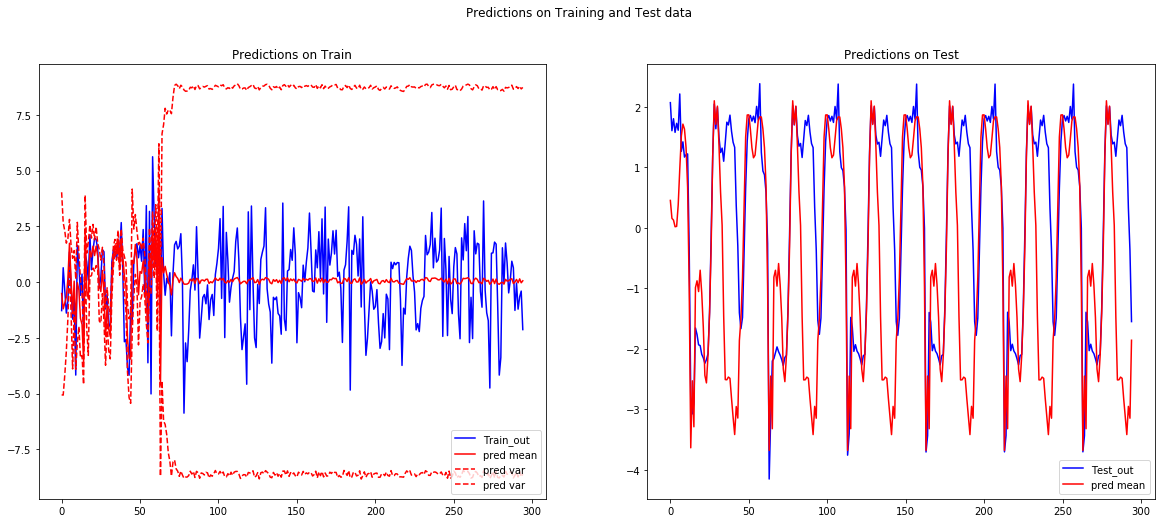

In [44]:
# Plot predictions
def plot_predictions(fig_no,posterior_train, posterior_test=None, layer_no = None):
    """
    Plots the output data along with posterior of the layer.
    Used for plotting the hidden states or
    
    layer_no: int or Normal posterior
        plot states of this layer (0-th is output). There is also some logic about compting
        the MSE, and aligning with actual data.
    """
    
    if layer_no is None: #default
        layer_no = 1

    if posterior_test is None:
        no_test_data = True
    else:
        no_test_data = False

    if isinstance(posterior_train, list): 
        layer_in_list = len(predictions_train)-1-layer_no # standard layer no (like in printing the model)
        predictions_train_layer = predictions_train[layer_in_list]
    else:
        predictions_train_layer = posterior_train

    if not no_test_data:
        if isinstance(posterior_test, list): 
            predictions_test_layer = predictions_test[layer_in_list]
        else:
            predictions_test_layer = posterior_test

    # Aligning the data ->
    # training of test data can be longer than leyer data because of the initial window.
    if out_train.shape[0] > predictions_train_layer.mean.shape[0]:
        out_train_tmp = out_train[win_out:]
    else:
        out_train_tmp = out_train
        
    if out_test.shape[0] > predictions_test_layer.mean.shape[0]:
        out_test_tmp = out_test[win_out:]
    else:
        out_test_tmp = out_test
    # Aligning the data <-
        
    if layer_no == 0:
        # Not anymore! Compute RMSE ignoring first output values of length "win_out"
        train_rmse = [comp_RMSE(predictions_train_layer.mean,
                                out_train_tmp)]
        print("Train overall RMSE: ", str(train_rmse))
        
        if not no_test_data:
            # Compute RMSE ignoring first output values of length "win_out"
            test_rmse = [comp_RMSE(predictions_test_layer.mean,
                                   out_test_tmp)]
            print("Test overall RMSE: ", str(test_rmse))
    
    # Plot predictions:
    if not no_test_data:
        fig5 = plt.figure(10,figsize=(20,8))
    else:
        fig5 = plt.figure(10,figsize=(10,8))
        
    fig5.suptitle('Predictions on Training and Test data')
    if not no_test_data:
        ax1 = plt.subplot(1,2,1)
    else:
        ax1 = plt.subplot(1,1,1)
    ax1.plot(out_train_tmp, label="Train_out", color = 'b')
    ax1.plot( predictions_train_layer.mean, label = 'pred mean', color = 'r' )
    ax1.plot( predictions_train_layer.mean +\
                     2*np.sqrt( predictions_train_layer.variance ), label = 'pred var', color='r', linestyle='--' )
    ax1.plot( predictions_train_layer.mean -\
                     2*np.sqrt( predictions_train_layer.variance ), label = 'pred var', color='r', linestyle='--' )
    ax1.legend(loc=4)        
    ax1.set_title('Predictions on Train')

    if not no_test_data:
        ax2 = plt.subplot(1,2,2)
        ax2.plot(out_test_tmp, label="Test_out", color = 'b')

        ax2.plot( predictions_test_layer.mean, label = 'pred mean', color = 'r' )
        #ax2.plot( predictions_test_layer.mean +\
        #                 2*np.sqrt( predictions_test_layer.variance ), label = 'pred var', color='r', linestyle='--' )
        #ax2.plot( predictions_test_layer.mean -\
        #                 2*np.sqrt( predictions_test_layer.variance ), label = 'pred var', color='r', linestyle='--' )
        ax2.legend(loc=4)        
        ax2.set_title('Predictions on Test')

        del ax2
    del ax1 
plot_predictions(7,predictions_train, predictions_test , layer_no = 0)

In [45]:
comp_RMSE(np.zeros( (len(out_train[20:]),1) ), out_train[20:] )

1.8982884835906451

In [46]:
out_train[20:].mean(0)

array([ 0.07638323])

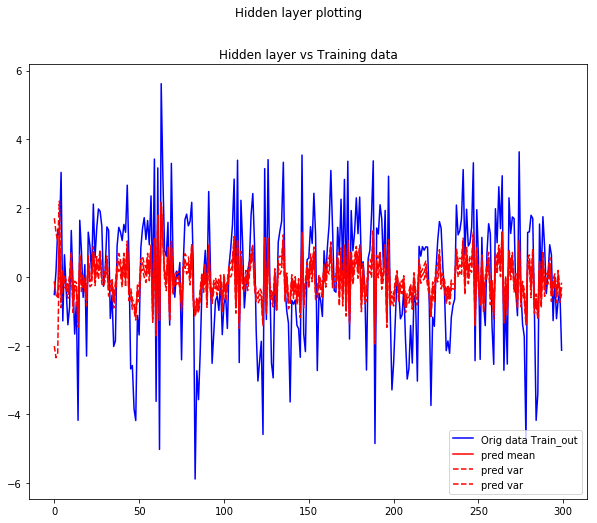

In [47]:
plot_hidden_states(8,m.layer_1.qX_0)
#plot_hidden_states(9,m.layer_2.qX_0)